# **Продвинутая оптимизация**

Оценка качества модели для каждой комбинации гиперпараметров является дорогостоящей частью оптимизации — на приведённых крохотных сетках по нескольким параметрам это занимает минуты, но в реальных масштабах это занимает часы и сутки. Поэтому в идеале мы хотим оптимизировать гиперпараметры самым эффективным образом. 

Один из способов  — это **байесовская оптимизация**. Она отличается от случайного поиска или поиска по сетке тем, что *учитывает предыдущие результаты*, а не выбирает комбинации из вариантов, не имеющих информации о прошлых оценках. Во многих случаях это позволяет найти лучшие значения гиперпараметров модели за меньшее количество времени. Таким образом, мы получаем и более быструю оптимизацию, и более качественный результат. Это два желаемых результата, особенно когда мы работаем с настройкой гиперпараметров моделей МО.

Существует несколько разных алгоритмов для этого типа оптимизации, но особенно используемым является **Tree-Structured Parzen Estimators (TPE)**.

In [5]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
import hyperopt
import optuna

from sklearn import linear_model, tree, ensemble, metrics, preprocessing #линейные моделиё
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from hyperopt import hp, fmin, tpe, Trials

%matplotlib inline
plt.style.use('seaborn')

dummies_data = pd.read_csv('data/adult_new.csv')

X = dummies_data.drop(['income'], axis=1)
y = dummies_data['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

# Производим нормализацию данных с помощью min-max нормализации
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

***
## **TREE-STRUCTURED PARZEN ESTIMATORS (TPE)**

1. На каждой итерации алгоритм TPE учитывает информацию о прошлых опробованных комбинациях гиперпараметров и только потом принимает решение, какой набор следует попробовать дальше. 

    Чтобы приступить к использованию TPE, необходимо выполнить несколько итераций с помощью случайного поиска. 

2. На следующем шаге происходит разделение собранных наборов на две группы:
   * в первую группу входят наборы, дающие наилучшие результаты после оценки;
   * во вторую — все остальные.
 
На изображении ниже: первая группа — красные точки находятся в области минимума целевой функции; вторая группа — синие точки, все остальные.

![](https://lms.skillfactory.ru/assets/courseware/v1/4f70e358ec0ba16d59159601c59fe154/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst-3-ml-7-9.png)

**Основная цель алгоритма** — найти набор гиперпараметров, который с большей вероятностью будет в первой группе и с меньшей вероятностью во второй группе. Таким образом, для принятия следующего решения используется целое распределение наилучших комбинаций — красные точки на графике.

3. Далее TPE моделирует вероятности правдоподобия для каждой из групп, используя формулу Байеса:

![](data/f2.PNG)

где ***x*** — гиперпараметры, ***y*** — соответствующая оценка качества модели.

4. Затем, используя вероятность правдоподобия из первой группы, отбирается набор комбинаций, которые с большей вероятностью попадут в первую группу и с меньшей вероятностью — во вторую. 

![](data/f3.PNG)

где ***p(x|y)*** — это вероятность гиперпараметров с учётом оценки целевой функции, ***l(x)*** — вероятность быть в первой группе, ***g(x)*** — вероятность быть во второй группе

Определяем ожидаемое улучшение для каждой комбинации:

![](data/f4.PNG)

   * где ***E*** — это знак математического ожидания.

5. Шаги 2-4  будет выполняться до тех пор, пока не будет достигнуто максимальное количество итераций. 

В итоге мы найдём наилучшую комбинацию гиперпараметров.

Более подробное описание алгоритма с математическими выкладками вы можете найти [здесь](https://ml-handbook.ru/chapters/hyperparameters_tuning/intro#tree-structured-parzen-estimator-tpe).

### **HYPEROPT**

**Hyperopt** — это библиотека Python с открытым исходным кодом на основе байесовской оптимизации, в которой реализован алгоритм **Tree-Structured Parzen Estimators (TPE)**.

Три шага для использования Hyperopt:

1. **Задание пространства поиска гиперпараметров.** 

Объявляем список гиперпараметров, тип распределения и его границы.

Основные типы:

* hp.choice(label, options) #равновероятный выбор из множества

* hp.randint(label, upper) #случайное целое число; random seed, например 

* hp.uniform(label, low, high) #равномерное непрерывное распределение

* hp.normal(label, mu, sigma) #нормальное непрерывное распределение

* hp.lognormal(mu, sigma) #логнормальное непрерывное распределение

Используйте для:

* **категориальных** — hp.choice;
* **целочисленных** —  hp.randit, hp.quniform;
* **непрерывных** — аналогично целочисленным и hp.normal, hp.uniform, hp.lognormal, hp.loguniform.

2. **Задание целевой функции.**

Создаём модель МО, передаём ей данные и оцениваем её на основе выбранной метрики. Можем минимизировать/максимизировать значение метрики.

3. **Задание алгоритма поиска:**

Random Search.
Tree of Parzen Estimators (TPE).

✍️ Посмотрим, как выполнить эти шаги с помощью Hyperopt.

Примечание. Если на этапе подбора гиперпараметров у вас возникла ошибка, не переживайте, это из-за разницы версий библиотеки.

Для версии hyperopt==0.2.5 все отработает верно.  
Для версии hyperopt==0.2.7 будет ошибка из-за изменений в определении параметра **rstate**, теперь вместо **rstate=np.random.RandomState(random_state)**, необходимо использовать другой генератор случайных чисел: **rstate=np.random.default_rng(random_state)**.

In [1]:
# Устанавливаем библиотеку
# !pip install hyperopt
# или
# !conda install -c conda-forge hyperopt

In [2]:
#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print("Версия Hyperopt : {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2.7


Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [3]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

Интерфейс Hyperopt отличается от Grid или RandomizedSearch, поэтому нам нужно создать функцию для минимизации. Она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции.

In [6]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [10]:
%%time
# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [00:54<00:00,  2.72s/trial, best loss: -0.7676454495714026]
Наилучшие значения гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}
CPU times: total: 54.3 s
Wall time: 54.4 s


In [11]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.77
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67


Мы можем продолжить поиск гиперпараметров, чтобы получить лучшие результаты.

Для байесовских оптимизаторов это возможно, так как они ориентируются на прошлые результаты: предыдущие входные данные для целевой функции и результирующие потери.

Hyperopt продолжит поиск с того места, где он остановился, если мы передадим ему объект **Trials**, который уже содержит информацию о предыдущих запусках.

Всегда сохраняйте свои предыдущие результаты!

In [13]:
# если необходимо продолжить подбор, 
# то увеличиваем max_evals(должен быть строго больше, чем на предыдущих итерациях) 
# и используем старый trials
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=23, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 23/23 [00:07<00:00,  2.39s/trial, best loss: -0.7981321839080461]
Наилучшие значения гиперпараметров {'max_depth': 21.0, 'min_samples_leaf': 2.0, 'n_estimators': 101.0}


Видим, что Hyperopt смог улучшить нашу метрику, причём за меньшее время.

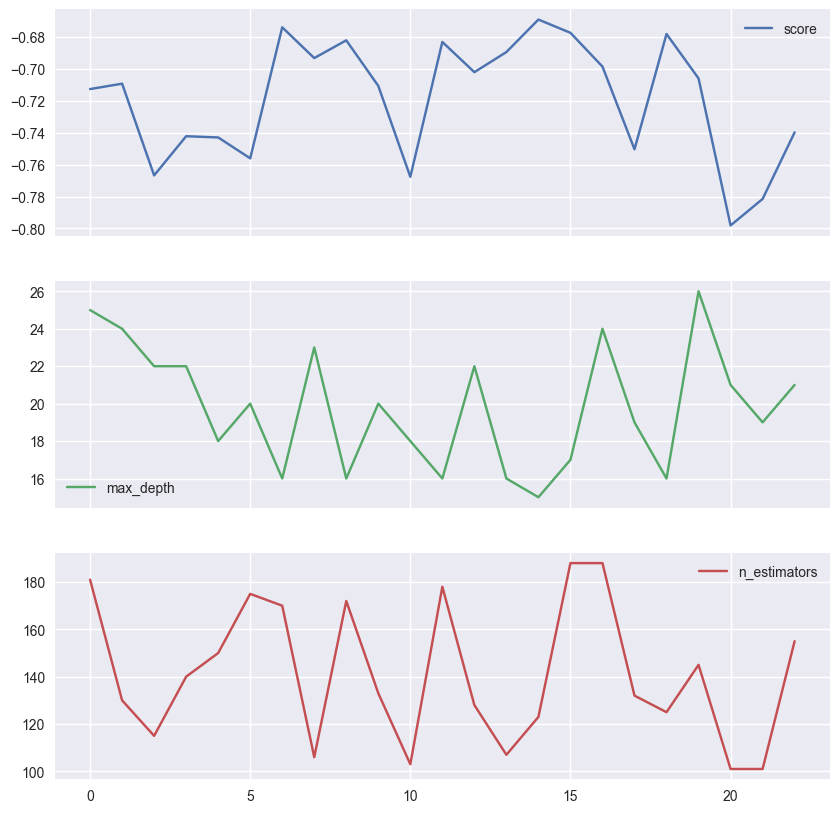

In [14]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

По графикам видно, что лучшая точность достигается именно в best_params. Однако заметьте, что метрика отрицательная, так как нам необходимо максимизировать нашу метрику, в то время как Hyperopt может только минимизировать.
***
***

Реализуйте настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:

* n_estimators = от 100 до 300 включительно с шагом 10
* min_samples_leaf = от 3 до 7 с шагом 1
* max_depth = от 15 до 40 с шагом 1
* Используйте Hyperopt с параметрами max_evals = 20.

В ответе укажите метрику f1 на тестовой выборке, значение округлите до двух знаков после запятой (например, 0.58).

In [15]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
       'max_depth' : hp.quniform('max_depth', 15, 40, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 7, 1)
      }

In [16]:
%%time
# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [01:16<00:00,  3.82s/trial, best loss: -0.7887954179344908]
Наилучшие значения гиперпараметров {'max_depth': 30.0, 'min_samples_leaf': 3.0, 'n_estimators': 130.0}
CPU times: total: 1min 16s
Wall time: 1min 16s


In [17]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.79
accuracy на тестовом наборе: 0.87
f1_score на тестовом наборе: 0.68


***
### **OPTUNA**

**Optuna** — это достаточно новый фреймворк/библиотека, разработанный специально для оптимизации гиперпараметров. Помимо байесовских алгоритмов, есть возможность удаления плохих комбинаций из рассмотрения. По умолчанию алгоритм удаляет комбинации, в которых модель даёт качество ниже медианы из уже рассмотренных. Optuna помогает  быстрее находить лучшие гиперпараметры и работает с большинством современных известных библиотек ML, таких как scikit-learn, xgboost, PyTorch, TensorFlow, skorch, lightgbm, Keras, fast-ai и другими.

Три шага для использования Optuna: 

1. **Задание пространства поиска гиперпараметров.**

Основные функции:

* suggest_categorical(name, choices) — для **категориальных** гиперпараметров;
* suggest_int(name,low,high,step=1,log=False) — для **целочисленных** гиперпараметров;
* suggest_float(name,low,high,step=None,log=False) — для **непрерывных** гиперпараметров;
* suggest_uniform(name,low,high) — для **целочисленных и непрерывных** гиперпараметров.

С помощью необязательных аргументов **step** и **log** можно дискретизировать или взять логарифм целочисленных и непрерывных параметров.

2. **Задание целевой функции.**

Создаём модель МО, передаём ей данные и оцениваем её на основе выбранной метрики, можем минимизировать/максимизировать значение метрики. На данном этапе будет обучена модель только на одной комбинации гиперпараметров.

3. **Создание объекта исследования create study.**

По умолчанию используется алгоритм поиска TPE (есть и другие варианты) и вызов метода **optimize()**, в который передаётся целевая функция, созданная на первом шаге. Выполняется заданное **n_trials** раз, подставляются различные комбинации гиперпараметров.

In [ ]:
# Устанавливаем библиотеку
# !pip install optuna
# или
#!conda install -c conda-forge optuna

In [18]:
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.0.3


Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [19]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [20]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-10-21 12:22:25,391] A new study created in memory with name: RandomForestClassifier
[I 2022-10-21 12:22:28,136] Trial 0 finished with value: 0.6983386223632629 and parameters: {'n_estimators': 145, 'max_depth': 20, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.6983386223632629.
[I 2022-10-21 12:22:30,669] Trial 1 finished with value: 0.7032657657657658 and parameters: {'n_estimators': 134, 'max_depth': 17, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.7032657657657658.
[I 2022-10-21 12:22:33,537] Trial 2 finished with value: 0.6882552870090635 and parameters: {'n_estimators': 157, 'max_depth': 17, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.7032657657657658.
[I 2022-10-21 12:22:37,048] Trial 3 finished with value: 0.6953898369001602 and parameters: {'n_estimators': 191, 'max_depth': 16, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.7032657657657658.
[I 2022-10-21 12:22:39,732] Trial 4 finished with value: 0.6667942950129224 and parameters: {'n_

CPU times: total: 56 s
Wall time: 56 s


In [21]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 117, 'max_depth': 26, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.84


In [22]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.87
f1_score на тестовом наборе: 0.68


In [23]:
%%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(optuna_rf, n_trials=10)

[I 2022-10-21 12:25:37,844] Trial 20 finished with value: 0.7531852930469604 and parameters: {'n_estimators': 111, 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 16 with value: 0.8358788734881257.
[I 2022-10-21 12:25:40,314] Trial 21 finished with value: 0.8288367978770456 and parameters: {'n_estimators': 110, 'max_depth': 25, 'min_samples_leaf': 2}. Best is trial 16 with value: 0.8358788734881257.
[I 2022-10-21 12:25:42,871] Trial 22 finished with value: 0.8356152283367193 and parameters: {'n_estimators': 112, 'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 16 with value: 0.8358788734881257.
[I 2022-10-21 12:25:45,727] Trial 23 finished with value: 0.7806283193806823 and parameters: {'n_estimators': 126, 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 16 with value: 0.8358788734881257.
[I 2022-10-21 12:25:48,232] Trial 24 finished with value: 0.8075647575513131 and parameters: {'n_estimators': 112, 'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 16 with va

CPU times: total: 26.3 s
Wall time: 26.3 s


**Видим, что Optuna также удалось увеличить метрику, но за меньшее время, чем Hyperopt.**

Рассмотрим различные визуализации, доступные через Optuna, которые помогают принимать лучшие решения, видеть влияние различных гиперпараметров на производительность модели.

Сначало необходимо проверить, доступна ли поддержка визуализации: is_available (), т.е. доступны ли правильные версии plotly и matplotlib для создания визуализаций.

In [24]:
optuna.visualization.is_available()

True

График истории оптимизации - отображает количество испытаний на оси Х и метрику на оси Y.

Следует использовать эту диаграмму, чтобы проверить, идет ли оптимизация гиперпараметров в правильном направлении или нет.

In [25]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

В нашем случае, все идет верно, метрика максимизируется.
***
График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [26]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра min_sampeles_leaf
***
График контура отношений гиперпараметров

Он показывает связь между различными комбинациями гиперпараметров и значение метрики для этих комбинаций в виде контурного графика.

In [27]:
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")

Точки с белым фоном это и есть лучшии комбинации n_estimator, max_depth.
***

Реализуйте настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:

* n_estimators = от 100 до 300 включительно с шагом 10
* min_samples_leaf = от 3 до 7 с шагом 1
* max_depth = от 15 до 40 с шагом 1
* Используйте Optuna с параметрами n_trails = 20.

В ответе укажите метрику f1 на тестовой выборке, значение округлите до двух знаков после запятой (например, 0.58).

In [28]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 10)
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [29]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-10-21 12:29:52,323] A new study created in memory with name: RandomForestClassifier
[I 2022-10-21 12:29:55,627] Trial 0 finished with value: 0.7231732008098657 and parameters: {'n_estimators': 160, 'max_depth': 35, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7231732008098657.
[I 2022-10-21 12:29:59,535] Trial 1 finished with value: 0.7520232790761116 and parameters: {'n_estimators': 190, 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.7520232790761116.
[I 2022-10-21 12:30:02,694] Trial 2 finished with value: 0.7616205462108881 and parameters: {'n_estimators': 150, 'max_depth': 37, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.7616205462108881.
[I 2022-10-21 12:30:06,784] Trial 3 finished with value: 0.7940362467636818 and parameters: {'n_estimators': 190, 'max_depth': 36, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.7940362467636818.
[I 2022-10-21 12:30:09,534] Trial 4 finished with value: 0.7923853784967378 and parameters: {'n_

CPU times: total: 1min 32s
Wall time: 1min 32s


In [30]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров {'n_estimators': 250, 'max_depth': 39, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.80
accuracy на тестовом наборе: 0.87
f1_score на тестовом наборе: 0.68


***
## **ПЛЮСЫ И МИНУСЫ РАССМОТРЕННЫХ ФРЕЙМВОРКОВ И БИБЛИОТЕК**

![](data/f5.PNG)  
![](data/f6.PNG)